In [1]:
#!/usr/bin/env python
# coding: utf-8

import argparse
import copy
import logging
import os
import pickle as pkl
import sys
from pathlib import Path

#import foolbox as fb
import matplotlib
import numpy as np
import torch
import torchvision
from matplotlib import pyplot as plt
from torch import autograd, nn
#from timm.data import Dataset, DatasetTar, create_loader, resolve_data_config, RealLabelsImagenet
from torch.utils.data import DataLoader, Subset
from torchvision.datasets import CIFAR10, ImageNet
from torchvision.transforms import Compose, Normalize, Resize, ToTensor

from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform
# ,apply_test_time_pool, load_checkpoint, is_model, list_models
from timm.models import create_model

matplotlib.use('Agg')


def get_img(x):
    tmp = x[:, ...].detach().cpu().numpy().transpose(1, 2, 0)
    return tmp


def prod(x):
    pr = 1.0
    for p in x.shape:
        pr *= p
    return pr

#coat_tiny and coat_mini are 4 patch size
mtype_dict = {'vit384': 'vit_base_patch16_384', 'vit224': 'vit_base_patch16_224',
              'wide-resnet': 'wide_resnet101_2', 'deit224': 'deit_base_patch16_224', 'bit_152_4': 'resnetv2_152x4_bitm',
              'deit224_distill':'deit_base_distilled_patch16_224', 'effnet': 'tf_efficientnet_l2_ns', 'resnet50':'resnet50', 'resnet101d':'resnet101d',
                'swin224':'swin_small_patch4_window7_224', 'swin224base': 'swin_base_patch4_window7_224', 'swin224large': 'swin_large_patch4_window7_224',
                'coat_tiny':'coat_tiny', 'coat_mini':'coat_mini',
                'beitv2_base_224': 'beitv2_base_patch16_224', 'beitv2_large_224':'beitv2_large_patch16_224','beit_base_224': 'beit_base_patch16_224', 'beit_large_224':'beit_large_patch16_224',
                'deit3_small_224':'deit3_small_patch16_224', 'deit3_medium_224':'deit3_medium_patch16_224', 'deit3_base_224': 'deit3_base_patch16_224',  'deit3_large_224':'deit3_large_patch16_224', 'deit3_huge_224_14': 'deit3_huge_patch14_224',
                'maxvit': 'maxvit_base_224', 'maxvit_large':'maxvit_xlarge_224',
                'conv2_base':'convnextv2_base', 'conv2_huge': 'convnextv2_huge', 'conv2_large':'convnextv2_large'
                    }
#att_type_dict = {'pgdlinf': fb.attacks.LinfProjectedGradientDescentAttack(rel_stepsize=0.033, steps=40, random_start=True),
#                 'pgdl2': fb.attacks.L2ProjectedGradientDescentAttack(steps=40, random_start=True)
#                 }


def get_patches(img, patch_size=16):
    bs, ch, sx, sy = img.size()
    patches = []
    for i in range(0, sx, patch_size):
        for j in range(0, sy, patch_size):
            patches.append(img[:, :, i:i+patch_size, j:j+patch_size])
    return patches


def reconstruct_img(patches, img):
    bs, ch, sx, sy = img.shape
    _, _, patch_size, _ = patches[0].shape
    recon = torch.zeros((bs, ch, sx, sy), device=device)
    k = 0
    for i in range(0, sx, patch_size):
        for j in range(0, sy, patch_size):
            recon[:, :, i:i+patch_size, j:j+patch_size] = patches[k]
            k += 1
    return recon


def MultiPatchGDAttack(model, img, label, loss=nn.CrossEntropyLoss(), iterations=40, device=torch.device('cuda:0'), max_num_patches=100, clip_flag=False, bounds=[-1, 1], patch_size=16, lr=0.033, epsilon=1.0, *args, **kwargs):
    base_img = copy.deepcopy(img)
    img = img.to(device)
    img.requires_grad_(True)
    bs, ch, sx, sy = img.size()
    label = label.to(device)
    print(f'epsilon:{epsilon}')
   # patch_size = 16
    #l2_norms = {}
    #max_val = 0.0
    #max_i, max_j = 0,0
    succ = 0
    grad_mags = {}
    # Calculating most salient patches
    pred = model(img)
    loss_val = loss(pred, label)
    grad_val = autograd.grad(loss_val, img)
    for i in range(0, sx, patch_size):
        for j in range(0, sy, patch_size):
            grad_mags[(i, j)] = torch.norm(
                grad_val[0][:, :, i:i+patch_size, j:j+patch_size], p="fro")
    sorted_tuples = sorted(grad_mags.items(), key=lambda x: x[1], reverse=True)
    grad_mags_sorted = [(k, v) for k, v in sorted_tuples]

    # We try to find minimum number of patches required to break image by checking with a fixed number of gradient updates
    for k in range(1, max_num_patches+1):
        img = copy.deepcopy(base_img).requires_grad_(
            True)  # Resetting image after each failure
        for i in range(iterations):
            pred = model(img)
            loss_val = loss(pred, label)
            grad_val = autograd.grad(loss_val, img)
            logging.debug(grad_val[0].shape)
            for p in range(k):
                p_x, p_y = grad_mags_sorted[p][0]
                img[:, :, p_x:p_x+patch_size, p_y:p_y+patch_size].data += (lr * \
                    (grad_val[0][:, :, p_x:p_x+patch_size, p_y:p_y+patch_size]).sign()) ## Infinity norm constraint. Here, we are constructing a mixed norm attack
            if clip_flag:
                img = torch.max(torch.min(img, img+epsilon), img-epsilon)
                img.clamp(bounds[0], bounds[1])
            with torch.no_grad():
                pred2 = model(img)
                if torch.argmax(pred2, dim=1) != label:
                    logging.info('Image broken at iteration {i}')
                    succ = 1
                    break
        if succ == 1:
            break
    return succ, base_img, img, k


def build_parser():
    parser = argparse.ArgumentParser()
    parser.add_argument(
        '-o', '--outdir', help='Output directory', default='results/')
    #parser.add_argument('-m', '--model', help='Model path')
    parser.add_argument('-mt', '--mtype', help='Model type', choices=list(mtype_dict.keys()), default='vit224')
    parser.add_argument('-dpath', help='Data path',
                        default='/data/datasets/Imagenet/val')
    parser.add_argument('--gpu', help='gpu to use', default=0, type=int)
 #   parser.add_argument('-at', '--att_type', help='Attack type',
 #                       choices=['pgdl2', 'pgdlinf', 'gd'], default='pgdlinf')
    parser.add_argument(
        '-it', '--iteration', help='No. of iterations', type=int, default=40)
    parser.add_argument('-mp', '--max_patches',
                        help='Max number of patches allowed to be perturbed', type=int, default=20)
    parser.add_argument('-ni', '--num_images',
                        help='Number of images to be tested', default=100, type=int)
    parser.add_argument(
        '-clip', '--clip', help='Clip perturbations to original image intensities', action='store_true')
    parser.add_argument('-lr', '--lr', help='Step size',
                        type=float, default=0.033)
    parser.add_argument('-ps', '--patch_size', help='Patch size', default=16, type=int)
    parser.add_argument('-si', '--start_idx', help='Start index for imagenet', default=0, type=int)
    parser.add_argument('-eps', '--epsilon', help='Epsilon bound for mixed norm attacks', default=1.0, type=float)
    #parser.add_argument('-ns', '--skipimages', help='No. of images to skip', default=20, type=int)
    return parser


In [2]:
x = 2
print(x)

2


In [3]:
device = torch.device(f'cuda:1' if torch.cuda.is_available() else 'cpu')


In [4]:
model_name = mtype_dict['swin224']
model = create_model(model_name, pretrained=True)
# model.reset_classifier(num_classes=10)
config = resolve_data_config({}, model=model)
print(config)
transforms = create_transform(**config)
#cifar10_test = CIFAR10(root='./datasets/test/', download=True, train=False, transform=transforms)
#indices = np.load('imagenet_indices.npy')
indices = np.load('indices_10k.npy')
imagenet_val = Subset(
    ImageNet(root='/imagenet/', split='val', transform=transforms), indices)
test_dl = DataLoader(imagenet_val, batch_size=1)

model = model.to(device)
#sd = torch.load('cifar10_vit.pth', map_location='cuda:0')
# model.load_state_dict(sd)
numparams = 0
for params in model.parameters():
    numparams += prod(params)

model.eval()
# TODO:Figure out a smarter way of calculating image bounds
bounds = [(0-config['mean'][0])/config['std'][0],
          (1-config['mean'][0])/config['std'][0]]
eps_val = 1/255
lr = 0.1
eps_val = (eps_val)/config['std'][0]
lr = lr/config['std'][0]
print(config, bounds, eps_val)
clean_acc = 0.0

/ext3/miniconda3/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


{'input_size': (3, 224, 224), 'interpolation': 'bicubic', 'mean': (0.485, 0.456, 0.406), 'std': (0.229, 0.224, 0.225), 'crop_pct': 0.9, 'crop_mode': 'center'}
{'input_size': (3, 224, 224), 'interpolation': 'bicubic', 'mean': (0.485, 0.456, 0.406), 'std': (0.229, 0.224, 0.225), 'crop_pct': 0.9, 'crop_mode': 'center'} [-2.1179039301310043, 2.2489082969432315] 0.017124753831663668


In [5]:
!pip install patchify

Defaulting to user installation because normal site-packages is not writeable


In [6]:
%matplotlib inline
from PIL import Image

from matplotlib import pyplot as plt
from matplotlib import image as mpimg
num_images =0
for idx, (img, label) in enumerate(test_dl):
    if idx > num_images:
        break
    img = img.to(device)
    #print(img.min(), img.max())
    label = label.to(device)
    #print(img.shape)
    bs, ch, sx, sy = img.shape 
    #image = mpimg.imread(img)
    #plt.imshow(img)
    image = img[0]
    print(image.shape)
    #plt.imshow(image.permute(1, 2, 0))
    #plt.show()
    
    #let's try to get the patches now
    from patchify import patchify
    print(image.shape)
    #print(image)
    image2 = np.asarray(image)
    #print(image2)
    patches = patchify(image2, (3,112,112), step=112) 
    print(patches.shape)
    #print(patches)
    patches = np.squeeze(patches, axis=0)
    print(patches.shape)
    #print(patches[0][1].shape)
    


    #plt.imshow(torch.from_numpy(patches[1][1]).permute(1,2,0))
    
#     for i in range(patches.shape[0]):
#         for j in range(patches.shape[1]):
#             patch = patches[i, j, 0]
#             patch = Image.fromarray(patch)
            #num = i * patches.shape[1] + j
            #patch.save(f"patch_{num}.jpeg")



torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
(1, 2, 2, 3, 112, 112)
(2, 2, 3, 112, 112)


torch.Size([3, 224, 224])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 2, 2, 3, 112, 112])


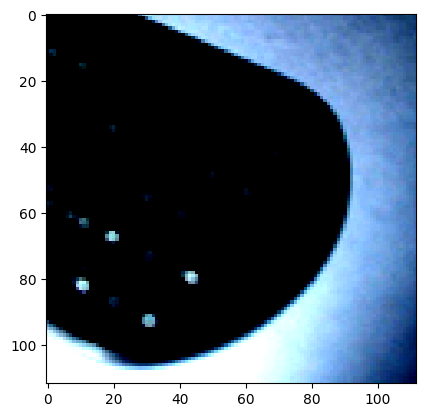

In [7]:
from einops import rearrange, reduce, repeat
print(image.shape)
y = rearrange(img, '1 c (b1 l) (b2 w) -> 1 b1 b2 c l w', b1 = 2, b2 = 2)
print(y.shape)
plt.imshow(y[0][1][1].permute(1,2,0))

In [8]:
xx = get_patches(img,16)
#print(xx)
#print(xx.shape)
y = rearrange(img, '1 c (b1 l) (b2 w) -> 1 b1 b2 c l w', b1 = 2, b2 = 2)
#print(y)
print(y.shape)

torch.Size([1, 2, 2, 3, 112, 112])


In [9]:
loss = nn.CrossEntropyLoss()
base_img = copy.deepcopy(img)
img = img.to(device)
img.requires_grad_(True)
bs, ch, sx, sy = img.size()
label = label.to(device)
#print(f'epsilon:{epsilon}')
# patch_size = 16
#l2_norms = {}
#max_val = 0.0
#max_i, max_j = 0,0
succ = 0
grad_mags = {}
# Calculating most salient patches
pred = model(img)
loss_val = loss(pred, label)
grad_val = autograd.grad(loss_val, img)
patch_size = 16

for i in range(0, sx, patch_size):
    for j in range(0, sy, patch_size):
        grad_mags[(i, j)] = torch.norm(
            grad_val[0][:, :, i:i+patch_size, j:j+patch_size], p="fro")
sorted_tuples = sorted(grad_mags.items(), key=lambda x: x[1], reverse=True)
grad_mags_sorted = [(k, v) for k, v in sorted_tuples]
print(grad_mags_sorted)

[((176, 176), tensor(2.1500)), ((208, 80), tensor(2.0110)), ((112, 128), tensor(1.9903)), ((112, 0), tensor(1.9406)), ((176, 160), tensor(1.8696)), ((160, 176), tensor(1.8605)), ((192, 160), tensor(1.7038)), ((128, 80), tensor(1.5519)), ((128, 144), tensor(1.4910)), ((96, 48), tensor(1.4482)), ((80, 64), tensor(1.3747)), ((96, 64), tensor(1.2846)), ((192, 112), tensor(1.2665)), ((160, 0), tensor(1.2455)), ((112, 64), tensor(1.2302)), ((96, 96), tensor(1.1866)), ((144, 128), tensor(1.1528)), ((208, 96), tensor(1.1153)), ((96, 80), tensor(1.1115)), ((144, 112), tensor(1.0793)), ((144, 144), tensor(1.0534)), ((112, 112), tensor(1.0345)), ((176, 96), tensor(1.0174)), ((160, 96), tensor(1.0082)), ((128, 128), tensor(0.9937)), ((128, 96), tensor(0.9901)), ((144, 48), tensor(0.9691)), ((160, 80), tensor(0.9678)), ((208, 112), tensor(0.9516)), ((0, 96), tensor(0.9348)), ((16, 176), tensor(0.9098)), ((208, 128), tensor(0.8971)), ((192, 0), tensor(0.8890)), ((160, 64), tensor(0.8783)), ((208, 0)

In [10]:
img2 = copy.deepcopy(img).to(device).requires_grad_(True)  # Resetting image after each failure

#just get the mask for top 5 values and take that mask and use it here
#can even make the iterations into bucketed fashion, so that it doesn't check every iteration - like every 5 iterations. 
# wasie bhi we are reports for 32 max iteration -> so, what's the point for broader anlaysis
#if we wnat to compare some deeper analysis, let's do that
for p in range(5):
    p_x, p_y = grad_mags_sorted[p][0]
    x = grad_val[0][:, :, p_x:p_x+patch_size, p_y:p_y+patch_size]
    img2[:, :, p_x:p_x+patch_size, p_y:p_y+patch_size].data += (lr * (x).sign())
#print(img2)    
#this image should match the final one we get

In [11]:
#basic sanity checks and norm calc sanity checks
firstrow = grad_val[0][0][0][0]
print(firstrow[:8])
print(grad_val[0].shape)
grad_val2 = rearrange(grad_val[0], '1 c (l ps1) (w ps2) -> 1 l w c ps1 ps2', ps1=16, ps2 = 16)
print(grad_val2.shape)
print(grad_val2[0][0][0][0][0])
xx = torch.norm(grad_val2,dim=(4,5),p="fro")
print(xx.shape)
final = torch.norm(xx,dim=(3),p="fro")
print(final)


tensor([-0.0014,  0.0044, -0.0008,  0.0047, -0.0165,  0.0071,  0.0298,  0.0089])
torch.Size([1, 3, 224, 224])
torch.Size([1, 14, 14, 3, 16, 16])
tensor([-0.0014,  0.0044, -0.0008,  0.0047, -0.0165,  0.0071,  0.0298,  0.0089,
        -0.0190, -0.0357, -0.0319, -0.0195, -0.0178,  0.0063,  0.0183,  0.0114])
torch.Size([1, 14, 14, 3])
tensor([[[0.4328, 0.3075, 0.3622, 0.4480, 0.4823, 0.8657, 0.9348, 0.8029,
          0.3667, 0.6585, 0.3185, 0.5043, 0.2411, 0.3865],
         [0.3446, 0.3695, 0.2394, 0.3495, 0.7612, 0.6553, 0.4107, 0.4707,
          0.2316, 0.3171, 0.3783, 0.9098, 0.3246, 0.3313],
         [0.4584, 0.3774, 0.2815, 0.3759, 0.3790, 0.0942, 0.2695, 0.8551,
          0.3445, 0.3911, 0.2435, 0.5736, 0.2483, 0.2647],
         [0.4522, 0.1675, 0.5755, 0.5306, 0.2310, 0.4588, 0.5434, 0.5310,
          0.5915, 0.3687, 0.5514, 0.2964, 0.2461, 0.2819],
         [0.6746, 0.3323, 0.3736, 0.4941, 0.4856, 0.6262, 0.5761, 0.4376,
          0.2864, 0.1868, 0.1927, 0.2506, 0.4152, 0.3912],
  

In [12]:
import numpy as np

def get_top_k_indices(mytensor, k):
    v, i = torch.topk(mytensor.flatten(), k)        
    mask = mytensor.ge(v[k-1])
    print(np.array(np.unravel_index(i.numpy(), mytensor.shape)).T) #this returns the list of indices if we want
    return mask
    
grad_val2 = rearrange(grad_val[0], '1 c (l ps1) (w ps2) -> l w c ps1 ps2', ps1=16, ps2 = 16)
print(grad_val2.shape)
xx = torch.norm(grad_val2,dim=(3,4),p="fro")
final = torch.norm(xx,dim=(2),p="fro")
print(final.shape)
get_indices = get_top_k_indices(final,5)
print(get_indices) #verifiying indices of top 5 - they llook good


torch.Size([14, 14, 3, 16, 16])
torch.Size([14, 14])
[[11 11]
 [13  5]
 [ 7  8]
 [ 7  0]
 [11 10]]
tensor([[False, False, False, False, False, False, False, False, False, False,
         False, False, False, False],
        [False, False, False, False, False, False, False, False, False, False,
         False, False, False, False],
        [False, False, False, False, False, False, False, False, False, False,
         False, False, False, False],
        [False, False, False, False, False, False, False, False, False, False,
         False, False, False, False],
        [False, False, False, False, False, False, False, False, False, False,
         False, False, False, False],
        [False, False, False, False, False, False, False, False, False, False,
         False, False, False, False],
        [False, False, False, False, False, False, False, False, False, False,
         False, False, False, False],
        [ True, False, False, False, False, False, False, False,  True, False,
   

In [13]:
get_indices_repeat = get_indices.unsqueeze(2).unsqueeze(3).unsqueeze(4).repeat(1,1,3,16,16)
fil_grad_val2 = grad_val2*get_indices_repeat
print(fil_grad_val2.shape)
grad_val3 = rearrange(fil_grad_val2, 'x1 x2 c ps1 ps2 -> 1 c (x1 ps1) (x2 ps2)')

torch.Size([14, 14, 3, 16, 16])


In [14]:
img3 = copy.deepcopy(img).to(device).requires_grad_(True)  # Resetting image after each failure
img3.data += lr*(grad_val3.sign())
print(img3.data)

tensor([[[[-0.7650, -0.7993, -0.7993,  ..., -1.1075, -1.0904, -1.1247],
          [-0.7479, -0.7650, -0.7650,  ..., -1.1075, -1.0562, -1.0904],
          [-0.7308, -0.7137, -0.7137,  ..., -1.1418, -1.1075, -1.0904],
          ...,
          [ 2.1119,  2.1119,  2.0948,  ..., -0.0629, -0.1143, -0.1314],
          [ 2.1290,  2.1119,  2.1119,  ..., -0.0972, -0.1657, -0.1657],
          [ 2.1119,  2.1290,  2.1290,  ..., -0.1486, -0.1999, -0.1828]],

         [[-0.6702, -0.6877, -0.6877,  ..., -1.0378, -1.0553, -1.0728],
          [-0.6352, -0.6527, -0.6527,  ..., -1.0553, -1.0553, -1.0728],
          [-0.6176, -0.6001, -0.6001,  ..., -1.0378, -1.0203, -1.0378],
          ...,
          [ 2.3410,  2.3585,  2.3585,  ...,  0.0651,  0.0126,  0.0126],
          [ 2.3410,  2.3410,  2.3585,  ...,  0.0476, -0.0224, -0.0049],
          [ 2.3585,  2.3761,  2.3761,  ...,  0.0301,  0.0126,  0.0126]],

         [[-0.4450, -0.4798, -0.4624,  ..., -0.8633, -0.8981, -0.9330],
          [-0.4101, -0.4275, -

In [19]:
print(img2.shape)
print(img2)
print(img3[0][0][176][176]==img2[0][0][176][176])
print(img[0][0][176][176]==img2[0][0][176][176])
print(img3[0][0][176]==img2[0][0][176])
print(img[0][0][176]==img2[0][0][176])
#verified

torch.Size([1, 3, 224, 224])
tensor([[[[-0.7650, -0.7993, -0.7993,  ..., -1.1075, -1.0904, -1.1247],
          [-0.7479, -0.7650, -0.7650,  ..., -1.1075, -1.0562, -1.0904],
          [-0.7308, -0.7137, -0.7137,  ..., -1.1418, -1.1075, -1.0904],
          ...,
          [ 2.1119,  2.1119,  2.0948,  ..., -0.0629, -0.1143, -0.1314],
          [ 2.1290,  2.1119,  2.1119,  ..., -0.0972, -0.1657, -0.1657],
          [ 2.1119,  2.1290,  2.1290,  ..., -0.1486, -0.1999, -0.1828]],

         [[-0.6702, -0.6877, -0.6877,  ..., -1.0378, -1.0553, -1.0728],
          [-0.6352, -0.6527, -0.6527,  ..., -1.0553, -1.0553, -1.0728],
          [-0.6176, -0.6001, -0.6001,  ..., -1.0378, -1.0203, -1.0378],
          ...,
          [ 2.3410,  2.3585,  2.3585,  ...,  0.0651,  0.0126,  0.0126],
          [ 2.3410,  2.3410,  2.3585,  ...,  0.0476, -0.0224, -0.0049],
          [ 2.3585,  2.3761,  2.3761,  ...,  0.0301,  0.0126,  0.0126]],

         [[-0.4450, -0.4798, -0.4624,  ..., -0.8633, -0.8981, -0.9330],
 